# Описание проекта. Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Ваша задача — построить модель, которая будет её предсказывать. Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

## Описание процесса обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены на крышке ковша.

Сначала происходит десульфурация — из стали выводят серу и корректируют её химический состав добавлением примесей. Затем сталь легируют — добавляют в неё куски сплава из бункера для сыпучих материалов или порошковую проволоку через специальный трайб-аппарат.

Прежде чем в первый раз ввести легирующие добавки, специалисты производят химический анализ стали и измеряют её температуру. Потом температуру на несколько минут повышают, уже после этого добавляют легирующие материалы и продувают сталь инертным газом, чтобы перемешать, а затем снова проводят измерения. Такой цикл повторяется до тех пор, пока не будут достигнуты нужный химический состав стали и оптимальная температура плавки.

Дальше расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. slab, «плита»).

In [5]:
!pip install catboost phik scipy

In [6]:
# Подключения библиотек
import os
import random
import requests
import copy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# импортируем phik
from phik.report import plot_correlation_matrix
from phik import report

# импортируем библиотеки для работы с progress bar
from tqdm import *
from tqdm.notebook import tqdm
tqdm.pandas()

# Импортируем модели
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import Pool, CatBoostRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

# Импортируем pytorch
import torch
import torch.nn as nn

In [7]:
from IPython.display import Markdown, display, HTML
def printmd(string):
    display(Markdown(string))

In [8]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [9]:
if torch.cuda.is_available():
    device = 'cuda'
    print(torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print('CPU')

NVIDIA GeForce RTX 3060


Зафиксируем `RANDOM_STATE`

In [11]:
RANDOM_STATE = 170125
set_seed(RANDOM_STATE)

Random seed set as 170125


## Шаг 1. Загрузка данных

Данные хранятся в `Sqlite`  — СУБД, в которой база данных представлена одним файлом. Она состоит из нескольких таблиц:
- `steel.data_arc` — данные об электродах;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

In [14]:
DB_FILENAME = 'ds-plus-final.db'

In [15]:
def download_file(url, filename):
  with requests.get(url, stream=True) as r:
      r.raise_for_status()
      with open(filename, 'wb') as f:
          pbar = tqdm(total=int(r.headers['Content-Length']))
          for chunk in r.iter_content(chunk_size=8192):
              if chunk:
                  f.write(chunk)
                  pbar.update(len(chunk))

In [16]:
if not os.path.isfile(DB_FILENAME):
    download_file('https://code.s3.yandex.net/data-scientist/ds-plus-final.db', DB_FILENAME)

Объявим учетные данные для подключения к базе данных

In [18]:
engine = create_engine(f'sqlite:///{DB_FILENAME}', echo=False) 

In [19]:
def primary_table_information(engine, table, limit):
    select_10_query = '''
    SELECT *
    FROM {}
    LIMIT {}
    '''
    count_all_query = '''
    SELECT COUNT(*)
    FROM {}
    '''
    printmd(f"Количество строк: {pd.read_sql_query(count_all_query.format(table), con = engine)['COUNT(*)'][0]}")
    df = pd.read_sql_query(select_10_query.format(table, limit), con = engine)
    display(df.head(limit))

### Таблица `steel.data_arc`
- `key` — номер партии;
- `BeginHeat` — время начала нагрева;
- `EndHeat` — время окончания нагрева;
- `ActivePower` — значение активной мощности;
- `ReactivePower` — значение реактивной мощности.

In [21]:
primary_table_information(engine, 'data_arc', 10)

Количество строк: 14876

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.381124,0.220351
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,0.261665,0.205527
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.710297,0.484962
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.786322,0.542517
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.101678,0.820856


### Таблица `steel.data_bulk`
- `key` — номер партии;
- `Bulk1 … Bulk15` — объём подаваемого материала.

In [23]:
primary_table_information(engine, 'data_bulk', 10)

Количество строк: 3129

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
1,2,None,None,None,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
2,3,None,None,None,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
3,4,None,None,None,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
4,5,None,None,None,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0
5,6,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,201.0,154.0
6,7,None,None,None,117.0,None,None,None,None,None,None,None,204.0,None,152.0,154.0
7,8,None,None,None,99.0,None,None,None,None,None,None,None,410.0,None,252.0,153.0
8,9,None,None,None,117.0,None,None,None,None,None,None,None,107.0,None,99.0,203.0
9,10,None,None,None,NaN,None,None,None,None,None,None,None,203.0,None,102.0,204.0


### Таблица `steel.data_bulk_time`
- `key` — номер партии;
- `Bulk1 … Bulk15` — время подачи материала.

In [25]:
primary_table_information(engine, 'data_bulk_time', 10)

Количество строк: 3129

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47
5,6,None,None,None,2019-05-03 13:57:27,None,None,None,None,None,None,None,2019-05-03 13:48:52,None,2019-05-03 14:09:42,2019-05-03 14:03:15
6,7,None,None,None,2019-05-03 14:18:58,None,None,None,None,None,None,None,2019-05-03 14:41:26,None,2019-05-03 14:30:50,2019-05-03 14:27:16
7,8,None,None,None,2019-05-03 15:17:58,None,None,None,None,None,None,None,2019-05-03 15:17:58,None,2019-05-03 15:13:18,2019-05-03 15:05:33
8,9,None,None,None,2019-05-03 16:03:08,None,None,None,None,None,None,None,2019-05-03 16:03:08,None,2019-05-03 16:00:16,2019-05-03 15:52:39
9,10,None,None,None,None,None,None,None,None,None,None,None,2019-05-03 16:38:11,None,2019-05-03 16:34:24,2019-05-03 16:29:56


### Таблица `steel.data_gas`
- `key` — номер партии;
- `gas` — объём подаваемого газа.

In [27]:
primary_table_information(engine, 'data_gas', 10)

Количество строк: 3239

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
5,6,11.273392
6,7,9.836267
7,8,15.171553
8,9,8.216623
9,10,6.529891


### Таблица steel.data_temp
- `key` — номер партии;
- `MesaureTime` — время замера;
- `Temperature` — значение температуры.

In [29]:
primary_table_information(engine, 'data_temp', 10)

Количество строк: 18092

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


### Таблица `steel.data_wire`
- `key` — номер партии;
- `Wire1 … Wire9` — объём подаваемых проволочных материалов.

In [31]:
primary_table_information(engine, 'data_wire', 10)

Количество строк: 3081

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,None,None,None,None,None,None,None,None
1,2,96.052315,None,None,None,None,None,None,None,None
2,3,91.160157,None,None,None,None,None,None,None,None
3,4,89.063515,None,None,None,None,None,None,None,None
4,5,89.238236,9.11456,None,None,None,None,None,None,None
5,6,99.109917,9.11456,None,None,None,None,None,None,None
6,7,98.061600,None,None,None,None,None,None,None,None
7,8,155.282394,None,None,None,None,None,None,None,None
8,9,113.393279,9.143681,None,None,None,None,None,None,None
9,10,81.244796,12.376,None,None,None,None,None,None,None


### Таблица `steel.data_wire_time`
- `key` — номер партии;
- `Wire1 … Wire9` — время подачи проволочных материалов.

In [33]:
primary_table_information(engine, 'data_wire_time', 10)

Количество строк: 3081

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
1,2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
2,3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
3,4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None
5,6,2019-05-03 13:57:27,2019-05-03 13:48:52,None,None,None,None,None,None,None
6,7,2019-05-03 14:18:58,None,None,None,None,None,None,None,None
7,8,2019-05-03 15:01:30,None,None,None,None,None,None,None,None
8,9,2019-05-03 15:45:44,2019-05-03 15:39:37,None,None,None,None,None,None,None
9,10,2019-05-03 16:27:00,2019-05-03 16:22:36,None,None,None,None,None,None,None


Во всех файлах столбец `key` содержит номер партии. В таблицах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

#### Промежуточный вывод
Произведено первичное ознакомление с данными в таблицах:
- `steel.data_arc` — данные об электродах. Таблица содержит несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры. Таблица содержит несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

Таблицы соответствуют описанию, можно приступать к исследовательскому анализу и предобработке

## Шаг 2. Исследовательский анализ и предобработка данных

In [37]:
def draw_boxplots(df, cols, labels, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        sns.boxplot(data = df, y=cols[i], ax=axs[i])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("")
    fig.suptitle(title, fontsize=30);

In [38]:
def draw_hists(df, cols, labels, title):
    fig, axs = plt.subplots(ncols=len(cols), nrows=1, figsize=(16, 4))
    for i in range(len(cols)):
        df[cols[i]].hist(ax=axs[i])
        axs[i].set_xlabel(labels[i])
        axs[i].set_ylabel("")
    fig.suptitle(title, fontsize=30);
    return fig, axs

In [39]:
def primary_info(df, limit=5):
    display(df.head(limit))
    display(df.info())
    printmd("**Пропущенные значения**")
    display(df.isna().sum())

### Для таблицы steel.data_arc:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Вам нужно либо удалить всю партию с аномальным значением, либо заменить аномальное значение, основываясь на нормальных наблюдениях.
- Попробуйте сгенерировать новые признаки, которые могут пригодиться при обучении: длительность нагрева, общую мощность, соотношение активной мощности к реактивной, количество запуска нагрева электродами и другие.
- При агрегировании наблюдений по ключу учитывайте порядок арифметических действий: сначала сгенерируйте новые признаки, затем уже агрегируйте наблюдения.

In [41]:
data_arc_df = pd.read_sql_query("SELECT * FROM data_arc", con = engine)

In [42]:
primary_info(data_arc_df)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

**Пропущенные значения**

key                     0
Начало нагрева дугой    0
Конец нагрева дугой     0
Активная мощность       0
Реактивная мощность     0
dtype: int64

Пропущенных значений нет

In [44]:
# Переименуем столбцы
data_arc_df.rename(inplace=True, columns={
    "Начало нагрева дугой": "start_heat_time", 
    "Конец нагрева дугой": "stop_heat_time", 
    "Активная мощность": "active_power", 
    "Реактивная мощность": "reactive_power"
})

# Приведем дату к типу datatime
data_arc_df['start_heat_time'] = pd.to_datetime(data_arc_df['start_heat_time'], format="%Y-%m-%d %H:%M:%S")
data_arc_df['stop_heat_time'] = pd.to_datetime(data_arc_df['stop_heat_time'], format="%Y-%m-%d %H:%M:%S")

Добавим новые признаки:
- Длительность нагрева
- Суммарная мощность
- Отношение мощностей `Реактивная мощность/Активная мощность`

In [46]:
data_arc_df['heat_delta_seconds'] = (data_arc_df['stop_heat_time']-data_arc_df['start_heat_time']).dt.seconds
data_arc_df['total_power'] = (data_arc_df['active_power']+data_arc_df['reactive_power'])
data_arc_df['power_ratio'] = (data_arc_df['reactive_power']/data_arc_df['active_power'])

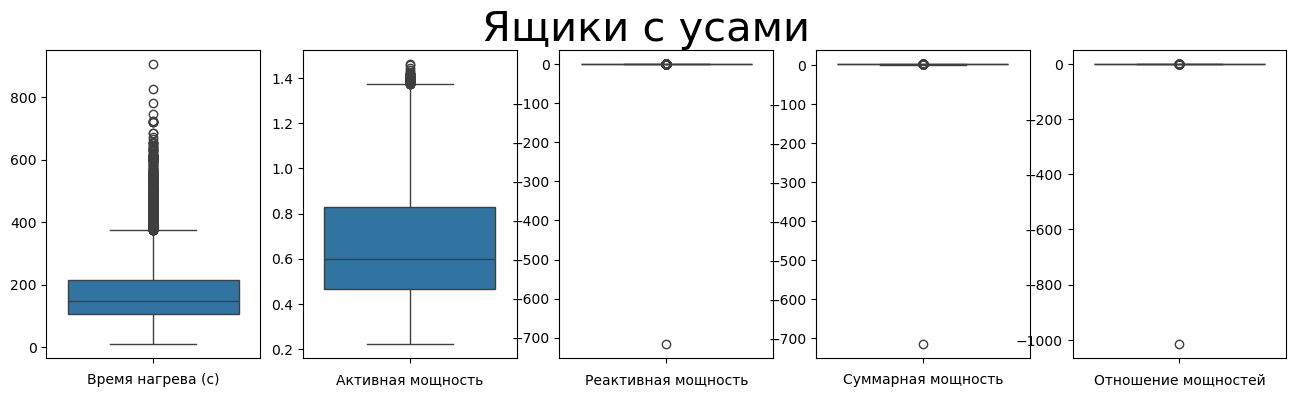

In [47]:
draw_boxplots(data_arc_df, 
              ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
              ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
               'Суммарная мощность', 'Отношение мощностей'],
              "Ящики с усами")

Удалим отрицательное аномальное значение в поле реактивная мощность

In [49]:
key = data_arc_df[data_arc_df['reactive_power'] < 0]['key']
data_arc_df = data_arc_df[~data_arc_df['key'].isin(key)]

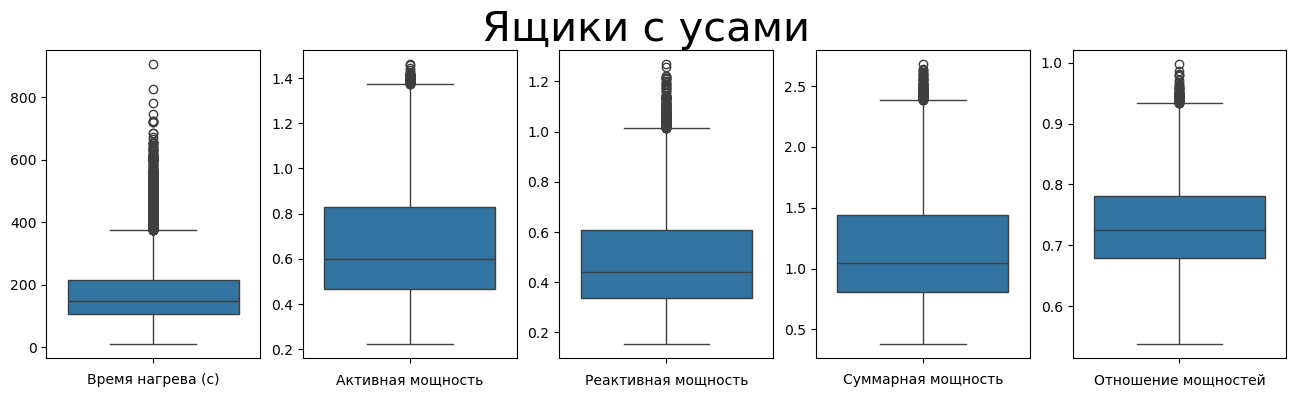

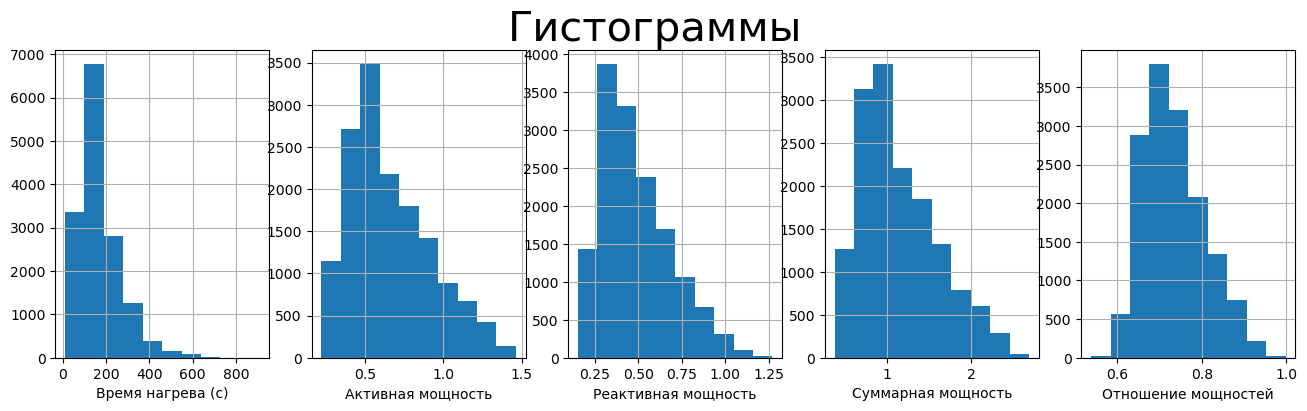

In [50]:
draw_boxplots(data_arc_df, 
              ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
              ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
               'Суммарная мощность', 'Отношение мощностей'],
              "Ящики с усами")
draw_hists(data_arc_df, 
           ['heat_delta_seconds', 'active_power', 'reactive_power', 'total_power', 'power_ratio'], 
           ['Время нагрева (с)', 'Активная мощность', 'Реактивная мощность', 
            'Суммарная мощность', 'Отношение мощностей'],
           "Гистограммы");

Аггрегируем таблицу по номеру партии

In [52]:
data_arc_df = data_arc_df.groupby('key').agg({
    'heat_delta_seconds': ['sum', 'mean'],
    'active_power': 'sum',
    'reactive_power': 'sum',
    'total_power': 'sum',
    'power_ratio': 'mean', 
    'key': 'count'
})
data_arc_df.columns = [col[0] + "_" + col[1] for col in data_arc_df.columns]

In [53]:
data_arc_df = data_arc_df[['heat_delta_seconds_sum', 'heat_delta_seconds_mean', 'total_power_sum', 'power_ratio_mean', 'active_power_sum', 'reactive_power_sum']]

In [54]:
data_arc_df.head()

,heat_delta_seconds_sum,heat_delta_seconds_mean,total_power_sum,power_ratio_mean,active_power_sum,reactive_power_sum
key,,,,,,
1,1098,219.60,5.179551,0.706569,3.036730,2.142821
2,811,202.75,3.592765,0.684080,2.139408,1.453357
3,655,131.00,7.001098,0.725034,4.063641,2.937457
4,741,185.25,4.763481,0.765897,2.706489,2.056992
5,869,217.25,3.940941,0.758599,2.252950,1.687991


In [55]:
data_arc_df.describe()

,heat_delta_seconds_sum,heat_delta_seconds_mean,total_power_sum,power_ratio_mean,active_power_sum,reactive_power_sum
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,794.691566,172.359237,5.322376,0.734810,3.067683,2.254693
std,332.439136,45.599742,2.099655,0.036500,1.208719,0.894787
min,57.000000,57.000000,0.463904,0.601191,0.267676,0.196228
25%,571.000000,140.000000,3.878944,0.709514,2.236693,1.631855
50%,770.000000,168.750000,5.158258,0.733500,2.984607,2.177210
75%,983.000000,200.400000,6.563466,0.757550,3.775574,2.788381
max,4189.000000,380.000000,21.324685,0.909516,12.375636,8.949049


### Для таблицы steel.data_bulk:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Обработайте пропуски. Пропуск означает, что материал не добавляли в партию.

In [57]:
data_bulk_df = pd.read_sql_query("SELECT * FROM data_bulk", index_col='key', con = engine)

In [58]:
primary_info(data_bulk_df)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,43.0,None,None,None,None,None,None,None,206.0,None,150.0,154.0
2,NaN,NaN,NaN,73.0,None,None,None,None,None,None,None,206.0,None,149.0,154.0
3,NaN,NaN,NaN,34.0,None,None,None,None,None,None,None,205.0,None,152.0,153.0
4,NaN,NaN,NaN,81.0,None,None,None,None,None,None,None,207.0,None,153.0,154.0
5,NaN,NaN,NaN,78.0,None,None,None,None,None,None,None,203.0,None,151.0,152.0


<class 'pandas.core.frame.DataFrame'>
Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Bulk 1   252 non-null    float64
 1   Bulk 2   22 non-null     float64
 2   Bulk 3   1298 non-null   float64
 3   Bulk 4   1014 non-null   float64
 4   Bulk 5   77 non-null     object 
 5   Bulk 6   576 non-null    object 
 6   Bulk 7   25 non-null     object 
 7   Bulk 8   1 non-null      object 
 8   Bulk 9   19 non-null     object 
 9   Bulk 10  176 non-null    object 
 10  Bulk 11  177 non-null    object 
 11  Bulk 12  2450 non-null   object 
 12  Bulk 13  18 non-null     object 
 13  Bulk 14  2806 non-null   object 
 14  Bulk 15  2248 non-null   object 
dtypes: float64(4), object(11)
memory usage: 391.1+ KB


None

**Пропущенные значения**

Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

Присутствуют пропущенные значения

In [60]:
bulk_idx = list([f"bulk_{x}" for x in range(1, 16)])

# Переименуем столбцы
data_bulk_df.rename(inplace=True, columns=dict(zip(
    list([f"Bulk {x}" for x in range(1, 16)]),
    bulk_idx
)))

# Приведем к типу float64
data_bulk_df[bulk_idx] = data_bulk_df[bulk_idx].astype('float64')

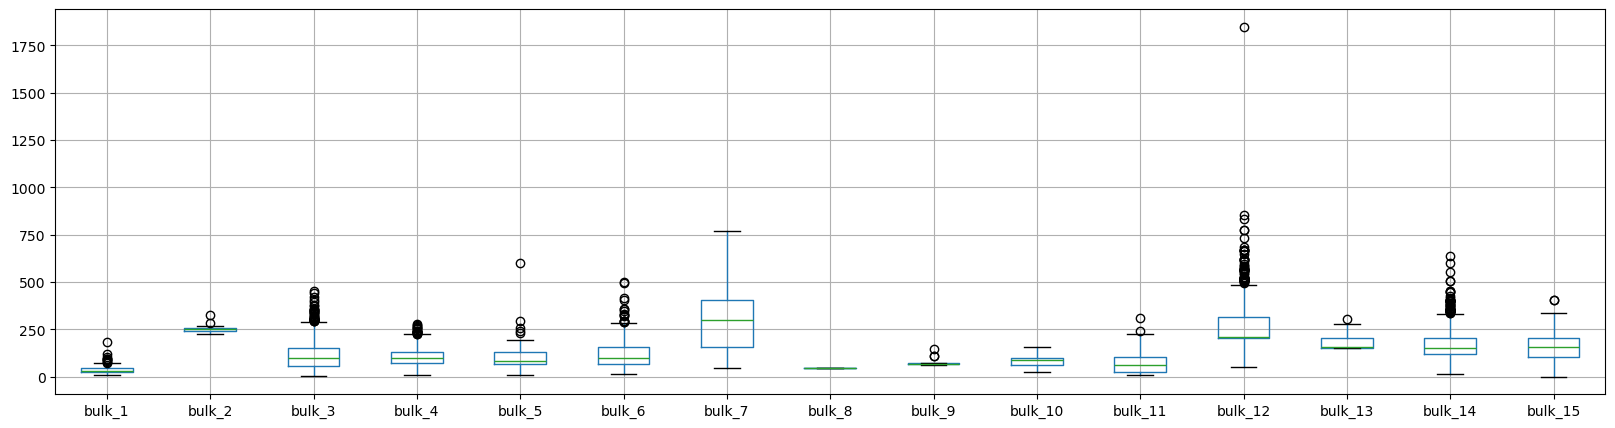

In [61]:
data_bulk_df.boxplot(column=bulk_idx, figsize=(20, 5));

Удалим аномальные значения в `bulk_12 > 1000` и `bulk_5 > 500`

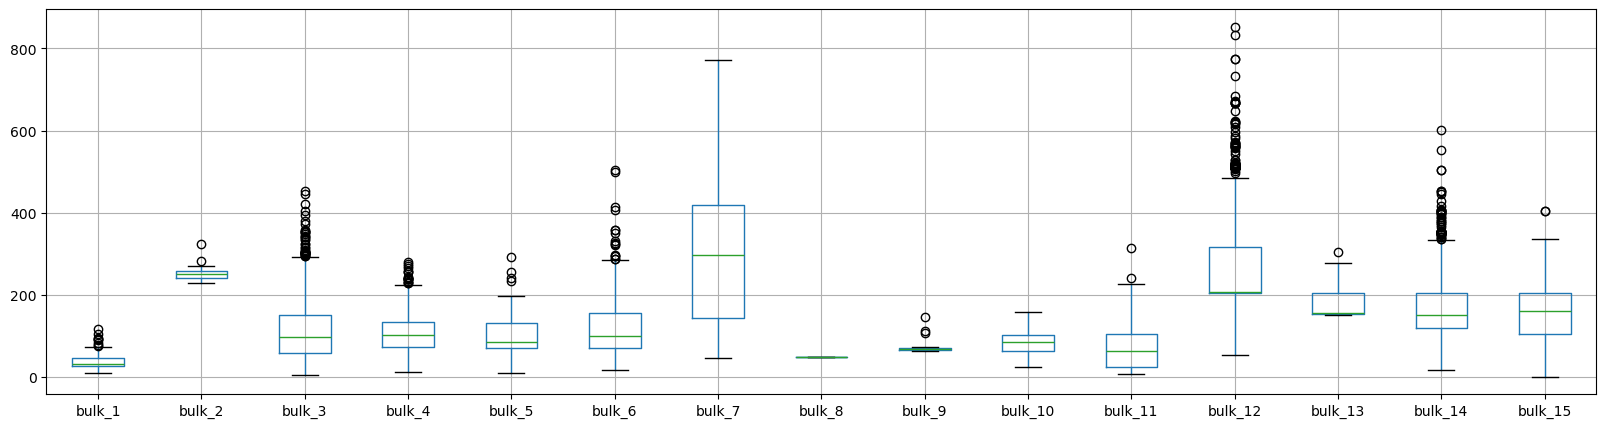

In [63]:
key = data_bulk_df[(data_bulk_df['bulk_5'] > 500) | (data_bulk_df['bulk_12'] > 1000)].index
data_bulk_df = data_bulk_df.drop(key)
data_bulk_df.boxplot(column=bulk_idx, figsize=(20, 5));

Пропуски означают, что материал не добавляли в партию, поэтому заменим их нулевым значением

In [65]:
data_bulk_df = data_bulk_df.fillna(0)
data_bulk_df.head()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
key,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [66]:
data_bulk_df.describe()

,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
count,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000,3127.000000
mean,3.103294,1.780301,47.165974,33.824113,2.442597,21.906300,2.313399,0.015670,0.463703,4.687560,4.348257,203.420211,1.042533,152.569236,115.359770
std,11.418543,21.224617,74.188575,56.050719,17.958449,55.507568,31.128112,0.876258,6.156356,20.163422,22.706575,148.581897,14.118742,80.649643,84.490298
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,0.000000,104.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,0.000000,148.000000,106.000000
75%,0.000000,0.000000,79.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,263.000000,0.000000,202.000000,204.000000
max,118.000000,325.000000,454.000000,281.000000,293.000000,503.000000,772.000000,49.000000,147.000000,159.000000,313.000000,853.000000,305.000000,601.000000,405.000000


### Для таблицы steel.data_bulk_time:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.

In [68]:
data_bulk_time_df = pd.read_sql_query("SELECT * FROM data_bulk_time", index_col='key', con = engine)

In [69]:
primary_info(data_bulk_time_df)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
key,,,,,,,,,,,,,,,
1,None,None,None,2019-05-03 11:28:48,None,None,None,None,None,None,None,2019-05-03 11:24:31,None,2019-05-03 11:14:50,2019-05-03 11:10:43
2,None,None,None,2019-05-03 11:36:50,None,None,None,None,None,None,None,2019-05-03 11:53:30,None,2019-05-03 11:48:37,2019-05-03 11:44:39
3,None,None,None,2019-05-03 12:32:39,None,None,None,None,None,None,None,2019-05-03 12:27:13,None,2019-05-03 12:21:01,2019-05-03 12:16:16
4,None,None,None,2019-05-03 12:43:22,None,None,None,None,None,None,None,2019-05-03 12:58:00,None,2019-05-03 12:51:11,2019-05-03 12:46:36
5,None,None,None,2019-05-03 13:30:47,None,None,None,None,None,None,None,2019-05-03 13:30:47,None,2019-05-03 13:34:12,2019-05-03 13:30:47


<class 'pandas.core.frame.DataFrame'>
Index: 3129 entries, 1 to 3241
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Bulk 1   252 non-null    object
 1   Bulk 2   22 non-null     object
 2   Bulk 3   1298 non-null   object
 3   Bulk 4   1014 non-null   object
 4   Bulk 5   77 non-null     object
 5   Bulk 6   576 non-null    object
 6   Bulk 7   25 non-null     object
 7   Bulk 8   1 non-null      object
 8   Bulk 9   19 non-null     object
 9   Bulk 10  176 non-null    object
 10  Bulk 11  177 non-null    object
 11  Bulk 12  2450 non-null   object
 12  Bulk 13  18 non-null     object
 13  Bulk 14  2806 non-null   object
 14  Bulk 15  2248 non-null   object
dtypes: object(15)
memory usage: 391.1+ KB


None

**Пропущенные значения**

Bulk 1     2877
Bulk 2     3107
Bulk 3     1831
Bulk 4     2115
Bulk 5     3052
Bulk 6     2553
Bulk 7     3104
Bulk 8     3128
Bulk 9     3110
Bulk 10    2953
Bulk 11    2952
Bulk 12     679
Bulk 13    3111
Bulk 14     323
Bulk 15     881
dtype: int64

In [70]:
# Переименуем столбцы
data_bulk_time_df.rename(inplace=True, columns=dict(zip(
    list([f"Bulk {x}" for x in range(1, 16)]),
    bulk_idx
)))

# Приведем к типу datetime
data_bulk_time_df[bulk_idx] = data_bulk_time_df[bulk_idx].apply(
    (lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S"))
)

In [71]:
def calc_max_delta(x):
    tt = [value for value in x if not pd.isnull(value)]
    return (max(tt)-min(tt)).seconds

In [72]:
def calc_mean_delta(x):
    tt = sorted([value for value in x if not pd.isnull(value)])
    p = tt[0]
    r_val = []
    for n in tt[1:]:
        r_val.append((n-p).seconds)
        p = n
    if len(r_val) == 0:
        return 0
    return sum(r_val)/len(r_val)

  0%|          | 0/3129 [00:00<?, ?it/s]

<Axes: >

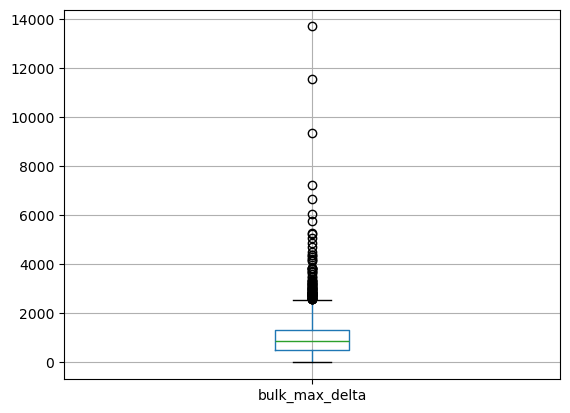

In [73]:
data_bulk_time_df['bulk_max_delta'] = data_bulk_time_df[bulk_idx].progress_apply(calc_max_delta, axis=1)
data_bulk_time_df[['bulk_max_delta']].boxplot()

  0%|          | 0/3129 [00:00<?, ?it/s]

<Axes: >

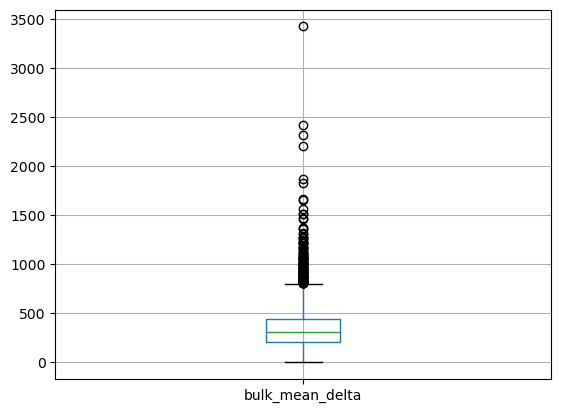

In [74]:
data_bulk_time_df['bulk_mean_delta'] = data_bulk_time_df[bulk_idx].progress_apply(calc_mean_delta, axis=1)
data_bulk_time_df[['bulk_mean_delta']].boxplot()

Удалим выбросы `max_delta > 8000` и `mean_delta > 2000`

In [76]:
key = data_bulk_time_df[(data_bulk_time_df['bulk_max_delta'] > 8000) | (data_bulk_time_df['bulk_mean_delta'] > 2000)].index

In [77]:
data_bulk_time_df = data_bulk_time_df.drop(key)

In [78]:
data_bulk_time_df = data_bulk_time_df[['bulk_max_delta', 'bulk_mean_delta']]
data_bulk_time_df.describe()

,bulk_max_delta,bulk_mean_delta
count,3124.000000,3124.000000
mean,952.363316,338.339207
std,717.352640,227.138476
min,0.000000,0.000000
25%,484.000000,208.666667
50%,876.000000,312.416667
75%,1308.000000,445.416667
max,6671.000000,1822.000000


### Для таблицы steel.data_gas:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.

In [80]:
data_gas_df = pd.read_sql_query("SELECT * FROM data_gas", index_col='key', con = engine)

In [81]:
primary_info(data_gas_df)

,Газ 1
key,
1,29.749986
2,12.555561
3,28.554793
4,18.841219
5,5.413692


<class 'pandas.core.frame.DataFrame'>
Index: 3239 entries, 1 to 3241
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Газ 1   3239 non-null   float64
dtypes: float64(1)
memory usage: 50.6 KB


None

**Пропущенные значения**

Газ 1    0
dtype: int64

In [82]:
# Переименуем столбцы
data_gas_df.rename(inplace=True, columns={'Газ 1': 'gas'})

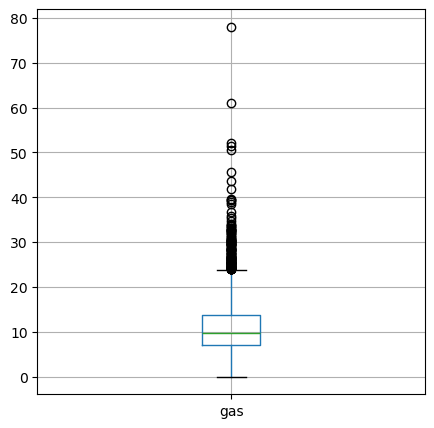

In [83]:
data_gas_df.boxplot(column='gas', figsize=(5, 5));

In [84]:
data_gas_df.describe()

,gas
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


### Для таблицы steel.data_temp:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределения признаков.
- Целевой признак — последняя температура партии. Начальную температуру партии можно использовать как входной признак. Любые другие промежуточные значения температуры приведут к утечке целевого признака, их нельзя использовать как входные.
- При агрегировании наблюдений используйте только ключи, у которых как минимум два наблюдения: первый и последний замеры температуры.
- Заказчик предупредил, что значения температуры ниже 1500 градусов — аномальные.

In [86]:
data_temp_df = pd.read_sql_query("SELECT * FROM data_temp", con = engine)

In [87]:
primary_info(data_temp_df, 10)

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
5,1,2019-05-03 11:30:38,1613.0
6,2,2019-05-03 11:34:04,1581.0
7,2,2019-05-03 11:38:40,1577.0
8,2,2019-05-03 11:46:09,1589.0
9,2,2019-05-03 11:49:38,1604.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   key           18092 non-null  int64 
 1   Время замера  18092 non-null  object
 2   Температура   14665 non-null  object
dtypes: int64(1), object(2)
memory usage: 424.2+ KB


None

**Пропущенные значения**

key                0
Время замера       0
Температура     3427
dtype: int64

In [88]:
data_temp_df.rename(inplace=True, columns={
    "Время замера": "measure_time", 
    "Температура": "temperature"
})

Приведем типы

In [90]:
# Приведем дату к типу datatime
data_temp_df['measure_time'] = pd.to_datetime(
    data_temp_df['measure_time'], format="%Y-%m-%d %H:%M:%S"
)
# Приведем температуру к типу float64
data_temp_df['temperature'] = data_temp_df['temperature'].astype('float64')

Удалим записи с значениями температуры ниже 1500 градусов

In [92]:
data_temp_df = data_temp_df[data_temp_df['temperature'] >= 1500]

Произведем аггрегацию по номеру партии

In [94]:
data_temp_df = data_temp_df.groupby('key').agg(['first', 'last', 'count'])
data_temp_df.columns = [col[0] + "_" + col[1] for col in data_temp_df.columns]

Оставим записи с количеством наблюдений более двух

In [96]:
data_temp_df = data_temp_df[data_temp_df['temperature_count'] > 1][['temperature_first', 'temperature_last']]

In [97]:
data_temp_df.head()

,temperature_first,temperature_last
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0


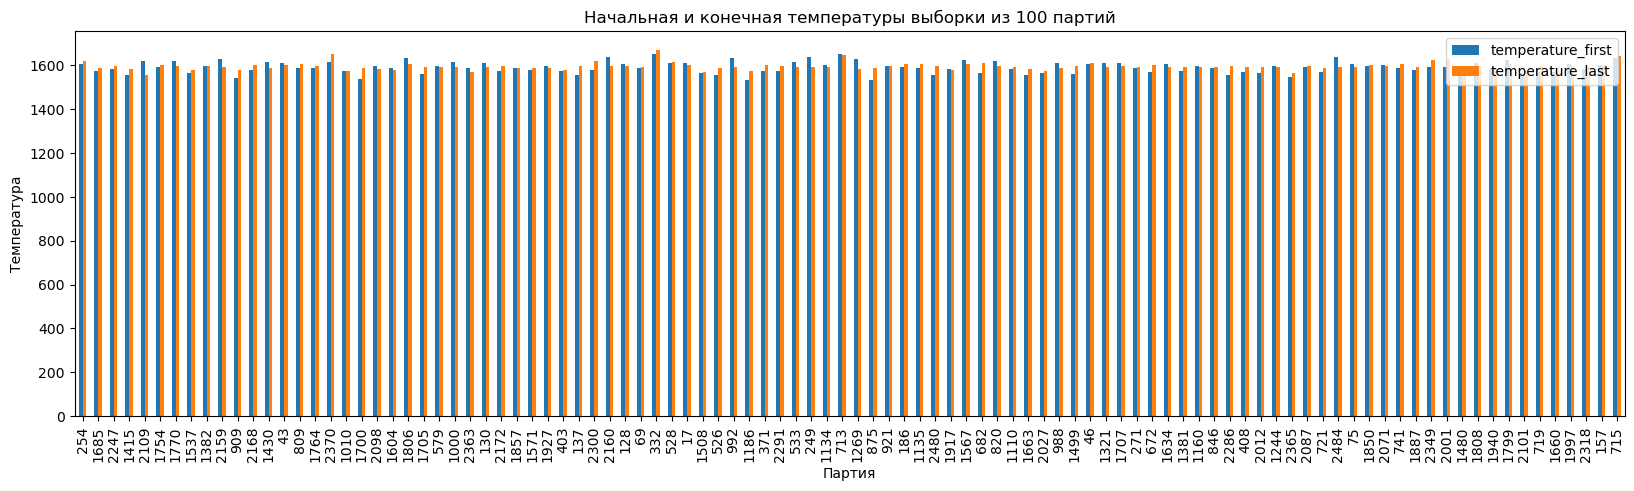

In [98]:
ax = data_temp_df.sample(100).plot(kind='bar', figsize=(20,5))
ax.set_xlabel("Партия")
ax.set_ylabel("Температура")
ax.set_title("Начальная и конечная температуры выборки из 100 партий");

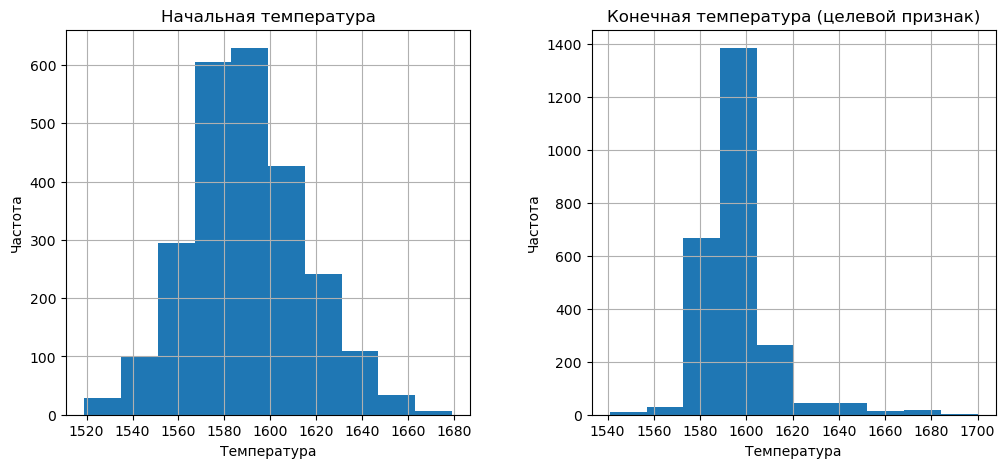

In [99]:
ax = data_temp_df.hist(figsize=(12, 5))
ax[0][0].set_xlabel("Температура")
ax[0][1].set_xlabel("Температура")
ax[0][0].set_ylabel("Частота")
ax[0][1].set_ylabel("Частота")
ax[0][0].set_title("Начальная температура")
ax[0][1].set_title("Конечная температура (целевой признак)");

In [100]:
data_temp_df.describe()

,temperature_first,temperature_last
count,2475.000000,2475.000000
mean,1589.029899,1595.336162
std,24.998058,16.023153
min,1519.000000,1541.000000
25%,1572.000000,1587.000000
50%,1588.000000,1593.000000
75%,1605.000000,1599.000000
max,1679.000000,1700.000000


### Для таблицы steel.data_wire:
- Обработайте пропуски. Пропуск означает, что материал не добавляли в эту партию.

In [102]:
data_wire_df = pd.read_sql_query("SELECT * FROM data_wire", index_col='key', con = engine)

In [103]:
primary_info(data_wire_df)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,60.059998,None,None,None,None,None,None,None,None
2,96.052315,None,None,None,None,None,None,None,None
3,91.160157,None,None,None,None,None,None,None,None
4,89.063515,None,None,None,None,None,None,None,None
5,89.238236,9.11456,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wire 1  3055 non-null   float64
 1   Wire 2  1079 non-null   object 
 2   Wire 3  63 non-null     object 
 3   Wire 4  14 non-null     object 
 4   Wire 5  1 non-null      object 
 5   Wire 6  73 non-null     object 
 6   Wire 7  11 non-null     object 
 7   Wire 8  19 non-null     object 
 8   Wire 9  29 non-null     object 
dtypes: float64(1), object(8)
memory usage: 240.7+ KB


None

**Пропущенные значения**

Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [104]:
wire_idx = list([f"wire_{x}" for x in range(1, 10)])

# Переименуем столбцы
data_wire_df.rename(inplace=True, columns=dict(zip(
    list([f"Wire {x}" for x in range(1, 10)]),
    wire_idx
)))

# Преобразуем к типу float64
data_wire_df[wire_idx] = data_wire_df[wire_idx].astype('float64')

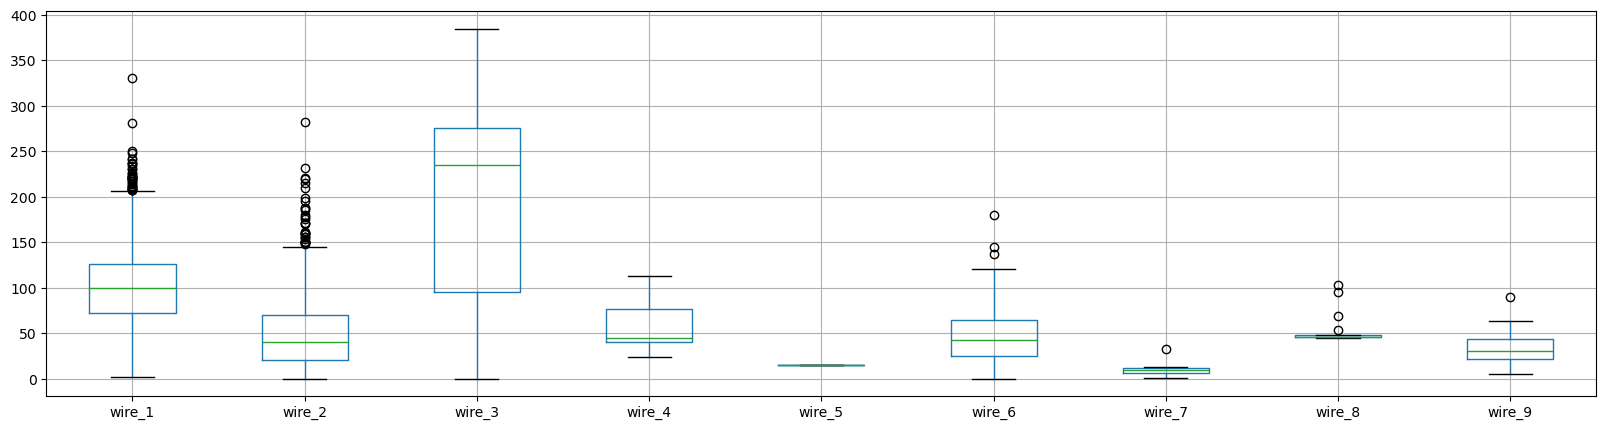

In [105]:
data_wire_df.boxplot(column=wire_idx, figsize=(20, 5));

Пропуски означают, что материал не добавляли в партию, поэтому заменим их нулевым значением

In [107]:
data_wire_df = data_wire_df.fillna(0)
data_wire_df.head()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
key,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [108]:
data_wire_df.describe()

,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
count,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000,3081.000000
mean,100.044411,17.712733,3.874524,0.261019,0.004911,1.137695,0.035842,0.330697,0.321492
std,42.841120,33.517734,30.310417,4.293865,0.272615,8.958111,0.774190,4.392677,3.806904
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,70.281120,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100.114563,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,125.798405,23.162880,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,330.314424,282.780152,385.008668,113.231044,15.132000,180.454575,32.847674,102.762401,90.053604


### Для таблицы steel.data_wire_time:
- Проведите исследовательский анализ данных: проверьте наличие пропусков и аномалий, изучите распределение признаков.
- Проверьте данные на адекватность: например, убедитесь, что подача материала не измеряется сутками. Обратите внимание: перед вами не стоит задача временных рядов.

In [110]:
data_wire_time_df = pd.read_sql_query("SELECT * FROM data_wire_time", index_col='key', con = engine)

In [111]:
primary_info(data_wire_time_df)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
key,,,,,,,,,
1,2019-05-03 11:06:19,None,None,None,None,None,None,None,None
2,2019-05-03 11:36:50,None,None,None,None,None,None,None,None
3,2019-05-03 12:11:46,None,None,None,None,None,None,None,None
4,2019-05-03 12:43:22,None,None,None,None,None,None,None,None
5,2019-05-03 13:20:44,2019-05-03 13:15:34,None,None,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
Index: 3081 entries, 1 to 3241
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Wire 1  3055 non-null   object
 1   Wire 2  1079 non-null   object
 2   Wire 3  63 non-null     object
 3   Wire 4  14 non-null     object
 4   Wire 5  1 non-null      object
 5   Wire 6  73 non-null     object
 6   Wire 7  11 non-null     object
 7   Wire 8  19 non-null     object
 8   Wire 9  29 non-null     object
dtypes: object(9)
memory usage: 240.7+ KB


None

**Пропущенные значения**

Wire 1      26
Wire 2    2002
Wire 3    3018
Wire 4    3067
Wire 5    3080
Wire 6    3008
Wire 7    3070
Wire 8    3062
Wire 9    3052
dtype: int64

In [112]:
# Переименуем столбцы
data_wire_time_df.rename(inplace=True, columns=dict(zip(
    list([f"Wire {x}" for x in range(1, 10)]),
    wire_idx
)))

# Приведем к типу datetime
data_wire_time_df[wire_idx] = data_wire_time_df[wire_idx].apply(
    (lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S"))
)

  0%|          | 0/3081 [00:00<?, ?it/s]

<Axes: >

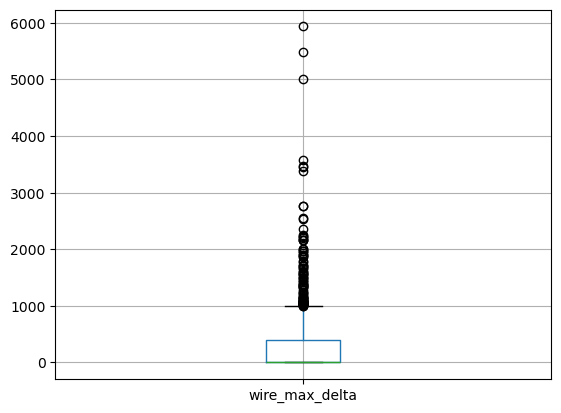

In [113]:
data_wire_time_df['wire_max_delta'] = data_wire_time_df[wire_idx].progress_apply(calc_max_delta, axis=1)
data_wire_time_df[['wire_max_delta']].boxplot()

  0%|          | 0/3081 [00:00<?, ?it/s]

<Axes: >

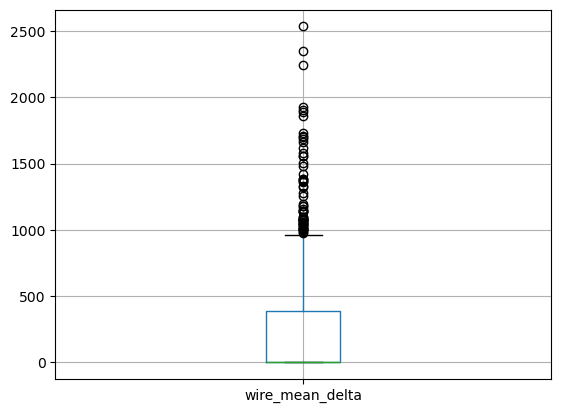

In [114]:
data_wire_time_df['wire_mean_delta'] = data_wire_time_df[wire_idx].progress_apply(calc_mean_delta, axis=1)
data_wire_time_df[['wire_mean_delta']].boxplot()

In [115]:
data_wire_time_df = data_wire_time_df[['wire_max_delta', 'wire_mean_delta']]

### Объедините таблицы по ключу:
- Каждой партии должно соответствовать одно наблюдение.
- Учтите: во все партии точно добавлялись сыпучие и проволочные материалы, везде была выполнена продувка газом и сплав всегда нагревался.
- Заказчик предупредил, что иногда наблюдается асинхронность в заданном времени разных датчиков. Если вы будете выстраивать хронологию процессов для разных партий, то можете столкнуться с тем, что полученная хронология не соответствует хронологии в описании. Не стоит воспринимать это как ошибку.
- Проведите исследовательский анализ данных объединённой таблицы и визуализируйте распределение каждого признака, напишите выводы.
- Проведите корреляционный анализ.

In [117]:
from functools import reduce

In [118]:
df_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True), [
    data_arc_df,
    data_bulk_df,
    data_bulk_time_df,
    data_gas_df,
    data_temp_df,
    data_wire_df,
    data_wire_time_df
])

In [119]:
primary_info(df_merged)

,heat_delta_seconds_sum,heat_delta_seconds_mean,total_power_sum,power_ratio_mean,active_power_sum,reactive_power_sum,bulk_1,bulk_2,bulk_3,bulk_4,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_max_delta,wire_mean_delta
key,,,,,,,,,,,,,,,,,,,,,
1,1098,219.60,5.179551,0.706569,3.036730,2.142821,0.0,0.0,0.0,43.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
2,811,202.75,3.592765,0.684080,2.139408,1.453357,0.0,0.0,0.0,73.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
3,655,131.00,7.001098,0.725034,4.063641,2.937457,0.0,0.0,0.0,34.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
4,741,185.25,4.763481,0.765897,2.706489,2.056992,0.0,0.0,0.0,81.0,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0
5,869,217.25,3.940941,0.758599,2.252950,1.687991,0.0,0.0,0.0,78.0,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,310,310.0


<class 'pandas.core.frame.DataFrame'>
Index: 2323 entries, 1 to 2499
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   heat_delta_seconds_sum   2323 non-null   int32  
 1   heat_delta_seconds_mean  2323 non-null   float64
 2   total_power_sum          2323 non-null   float64
 3   power_ratio_mean         2323 non-null   float64
 4   active_power_sum         2323 non-null   float64
 5   reactive_power_sum       2323 non-null   float64
 6   bulk_1                   2323 non-null   float64
 7   bulk_2                   2323 non-null   float64
 8   bulk_3                   2323 non-null   float64
 9   bulk_4                   2323 non-null   float64
 10  bulk_5                   2323 non-null   float64
 11  bulk_6                   2323 non-null   float64
 12  bulk_7                   2323 non-null   float64
 13  bulk_8                   2323 non-null   float64
 14  bulk_9                   2323

None

**Пропущенные значения**

heat_delta_seconds_sum     0
heat_delta_seconds_mean    0
total_power_sum            0
power_ratio_mean           0
active_power_sum           0
reactive_power_sum         0
bulk_1                     0
bulk_2                     0
bulk_3                     0
bulk_4                     0
bulk_5                     0
bulk_6                     0
bulk_7                     0
bulk_8                     0
bulk_9                     0
bulk_10                    0
bulk_11                    0
bulk_12                    0
bulk_13                    0
bulk_14                    0
bulk_15                    0
bulk_max_delta             0
bulk_mean_delta            0
gas                        0
temperature_first          0
temperature_last           0
wire_1                     0
wire_2                     0
wire_3                     0
wire_4                     0
wire_5                     0
wire_6                     0
wire_7                     0
wire_8                     0
wire_9        

Прверим датасет на мультиколлинеарность

In [120]:
cols = list(df_merged.columns)

C:\Users\Evgeniy\anaconda3\Lib\site-packages\phik\data_quality.py:72: UserWarning: Not enough unique value for variable wire_5 for analysis 1. Dropping this column
  warnings.warn(


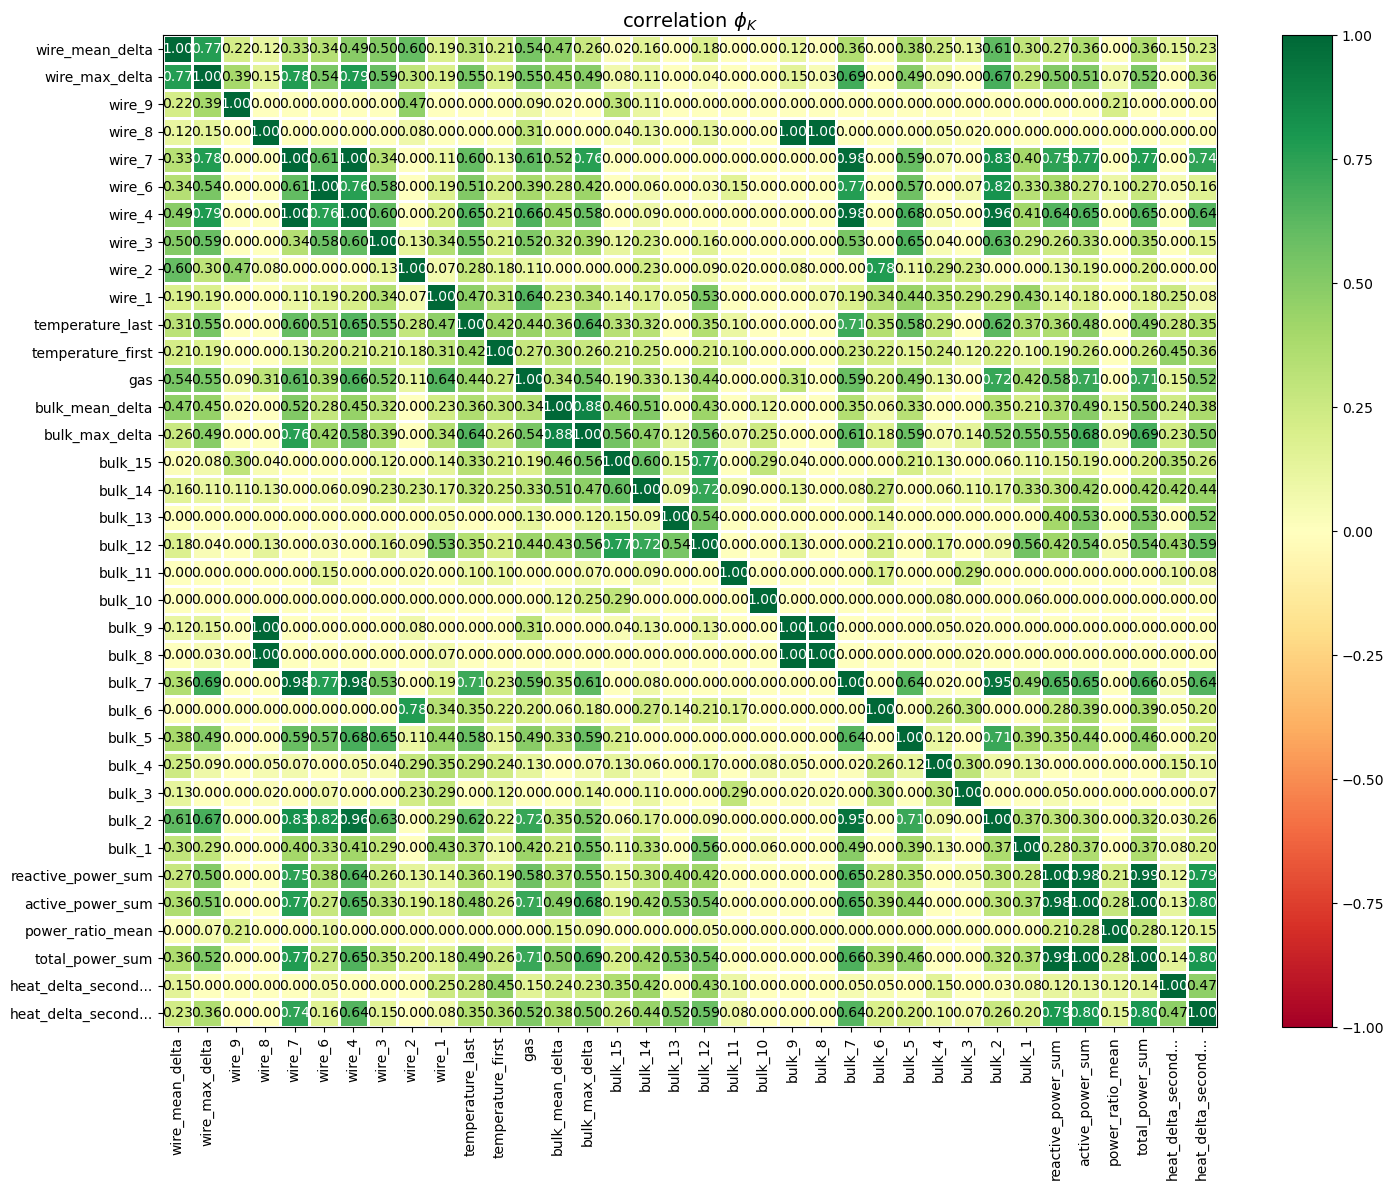

In [121]:
phik_overview = df_merged[cols].phik_matrix(interval_cols=cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    figsize=(15, 12)
);

Видно, что сильной корреляционной связью обладают признаки `wire_8`, `wire_7`, `wire_4`, `bulk_7`, `reactive_power_sum`, `active_power_sum`. Исключим их из выборки

In [122]:
[cols.remove(x) for x in ['wire_8', 'wire_7', 'wire_4', 'bulk_7', 'reactive_power_sum', 'active_power_sum']]

[None, None, None, None, None, None]

### Подготовьте данные для обучения:
- Выберите признаки, которые будете использовать для обучения, учитывайте особенности данных и выбранных моделей.
- Разделите данные на тренировочную и тестовую выборки (test_size = 0.25).
- Подготовьте выборки для обучения, учитывайте особенности выбранных моделей.

## Шаг 3. Обучение модели

In [125]:
models = {}
target = 'temperature_last'
cols.remove(target)

In [126]:
X = df_merged[cols]
y = df_merged[target]

Разделим выборку на тренировочную и тестовую

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = RANDOM_STATE)

Произведем шкалирование признаков

In [128]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Линейная регрессия

In [129]:
lr_grid = GridSearchCV(
    estimator=LinearRegression(),
    cv=5,
    param_grid={},
    scoring='neg_mean_absolute_error', 
    verbose=3
)

lr_grid.fit(X_train_scaled, y_train)

models['LinearRegression'] = (lr_grid.best_score_, lr_grid.best_estimator_)

print(f"MAE score = {abs(lr_grid.best_score_):0.2f}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END .................................., score=-6.435 total time=   0.0s
[CV 2/5] END .................................., score=-6.399 total time=   0.0s
[CV 3/5] END .................................., score=-5.651 total time=   0.0s
[CV 4/5] END .................................., score=-6.409 total time=   0.0s
[CV 5/5] END .................................., score=-6.333 total time=   0.0s
MAE score = 6.25


### Решающее дерево или случайный лес

In [131]:
fr_params = {
    'n_estimators': [100, 200],
    'max_depth': [8, 16],
    'min_samples_split': [8, 16]
}
fr_grid = GridSearchCV(
    estimator=RandomForestRegressor(
        criterion='absolute_error',
        random_state=RANDOM_STATE
    ),
    param_grid=fr_params,
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=3
)

fr_grid.fit(X_train_scaled, y_train)

models['RandomForestRegressor'] = (fr_grid.best_score_, fr_grid.best_estimator_)

print(f"MAE score = {abs(fr_grid.best_score_):0.2f}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END max_depth=8, min_samples_split=8, n_estimators=100;, score=-7.074 total time=  10.1s
[CV 2/5] END max_depth=8, min_samples_split=8, n_estimators=100;, score=-6.312 total time=  10.0s
[CV 3/5] END max_depth=8, min_samples_split=8, n_estimators=100;, score=-5.900 total time=  10.4s
[CV 4/5] END max_depth=8, min_samples_split=8, n_estimators=100;, score=-6.225 total time=  10.2s
[CV 5/5] END max_depth=8, min_samples_split=8, n_estimators=100;, score=-6.367 total time=   9.8s
[CV 1/5] END max_depth=8, min_samples_split=8, n_estimators=200;, score=-7.050 total time=  20.1s
[CV 2/5] END max_depth=8, min_samples_split=8, n_estimators=200;, score=-6.329 total time=  20.6s
[CV 3/5] END max_depth=8, min_samples_split=8, n_estimators=200;, score=-5.892 total time=  20.4s
[CV 4/5] END max_depth=8, min_samples_split=8, n_estimators=200;, score=-6.212 total time=  20.0s
[CV 5/5] END max_depth=8, min_samples_split=8, n_estimator

### Бустинги

In [133]:
cbr_params = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.001, 0.01],
    'depth': [2, 4, 6]
}
cbr_grid = GridSearchCV(
    estimator=CatBoostRegressor(
        random_state=RANDOM_STATE,
        logging_level='Silent',
        loss_function='MAE'
    ),
    param_grid=cbr_params,
    cv=5, 
    scoring='neg_mean_absolute_error', 
    verbose=3
)

cbr_grid.fit(X_train_scaled, y_train)
models['CatBoostRegressor'] = (cbr_grid.best_score_, cbr_grid.best_estimator_)

print(f"MAE score = {abs(cbr_grid.best_score_):0.2f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END depth=2, iterations=100, learning_rate=0.001;, score=-8.804 total time=   0.2s
[CV 2/5] END depth=2, iterations=100, learning_rate=0.001;, score=-8.216 total time=   0.0s
[CV 3/5] END depth=2, iterations=100, learning_rate=0.001;, score=-7.504 total time=   0.0s
[CV 4/5] END depth=2, iterations=100, learning_rate=0.001;, score=-8.351 total time=   0.0s
[CV 5/5] END depth=2, iterations=100, learning_rate=0.001;, score=-7.615 total time=   0.0s
[CV 1/5] END depth=2, iterations=100, learning_rate=0.01;, score=-8.326 total time=   0.0s
[CV 2/5] END depth=2, iterations=100, learning_rate=0.01;, score=-7.698 total time=   0.0s
[CV 3/5] END depth=2, iterations=100, learning_rate=0.01;, score=-7.057 total time=   0.0s
[CV 4/5] END depth=2, iterations=100, learning_rate=0.01;, score=-7.796 total time=   0.0s
[CV 5/5] END depth=2, iterations=100, learning_rate=0.01;, score=-7.238 total time=   0.0s
[CV 1/5] END depth=2, it

### Нейронные сети

Получим тренировочную и валидационную выборки

In [136]:
X_train_scaled_tensor, X_valid_scaled_tensor, y_train_tensor, y_valid_tensor = train_test_split(
    torch.tensor(X_train_scaled, dtype=torch.float), 
    torch.tensor(y_train.values, dtype=torch.float), 
    test_size = 0.25,
    random_state = RANDOM_STATE
)
X_train_scaled_tensor.shape, X_valid_scaled_tensor.shape, y_train_tensor.shape, y_valid_tensor.shape

(torch.Size([1306, 30]),
 torch.Size([436, 30]),
 torch.Size([1306]),
 torch.Size([436]))

In [137]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3) 
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        self.fa1 = nn.ELU()
        self.fa2 = nn.LeakyReLU()
        self.fa3 = nn.ELU()
        self.fa4 = nn.ReLU()
        self.dp1 = nn.Dropout()
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.dp2 = nn.Dropout()
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.fa1(out)
        out = self.dp1(out)
        out = self.fc2(out)
        # out = self.bn2(out)
        out = self.fa2(out)
        # out = self.dp2(out)
        out = self.fc3(out)
        out = self.fa3(out)
        out = self.fc4(out)
        out = self.fa4(out)
        
        return out

In [138]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = X_train.shape[1]*4
n_hidden_neurons_2 = X_train.shape[1]*2
n_hidden_neurons_3 = X_train.shape[1]//2
n_out_neurons = 1

In [161]:
lr=0.001
num_epochs = 10000
per_epochs = 100

In [163]:
def MAELoss(yhat,y):
    return torch.abs(yhat - y).mean()

In [165]:
net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)

loss = MAELoss
mae_min = float('inf')
best_params = None

for epoch in range(num_epochs):
    net.train()
    optimizer.zero_grad()
    preds = net.forward(X_train_scaled_tensor).flatten()
    loss_value = loss(preds, y_train_tensor)
    loss_value.backward()
    optimizer.step()

    if epoch % per_epochs == 0 or epoch == num_epochs - 1:
        net.eval()
        valid_preds = net(X_valid_scaled_tensor).flatten()
        mae = loss(valid_preds, y_valid_tensor)
        if mae_min > mae:
            mae_min = mae
            best_params = copy.deepcopy(net.state_dict())
        print(f"Epoch {epoch}/{num_epochs}, MAE = {mae}, best MAE = {mae_min}")

Epoch 0/10000, MAE = 1593.8016357421875, best MAE = 1593.8016357421875
Epoch 100/10000, MAE = 1499.2015380859375, best MAE = 1499.2015380859375
Epoch 200/10000, MAE = 399.1731262207031, best MAE = 399.1731262207031
Epoch 300/10000, MAE = 172.3787078857422, best MAE = 172.3787078857422
Epoch 400/10000, MAE = 155.3455810546875, best MAE = 155.3455810546875
Epoch 500/10000, MAE = 136.59979248046875, best MAE = 136.59979248046875
Epoch 600/10000, MAE = 111.24535369873047, best MAE = 111.24535369873047
Epoch 700/10000, MAE = 75.27154541015625, best MAE = 75.27154541015625
Epoch 800/10000, MAE = 53.40485763549805, best MAE = 53.40485763549805
Epoch 900/10000, MAE = 50.08421325683594, best MAE = 50.08421325683594
Epoch 1000/10000, MAE = 48.814300537109375, best MAE = 48.814300537109375
Epoch 1100/10000, MAE = 40.32621383666992, best MAE = 40.32621383666992
Epoch 1200/10000, MAE = 36.60039520263672, best MAE = 36.60039520263672
Epoch 1300/10000, MAE = 32.19685745239258, best MAE = 32.196857452

In [167]:
net.load_state_dict(best_params)
models['NN'] = (mae_min.item(), net)

In [169]:
pd.DataFrame({ 
    'Модель': models.keys(), 
    'MAE': [f"{abs(models[x][0]):0.2f}" for x in models], 
})

,Модель,MAE
0,LinearRegression,6.25
1,RandomForestRegressor,6.30
2,CatBoostRegressor,6.12
3,NN,6.56


In [177]:
model = models['CatBoostRegressor'][1]

## Шаг 4. Тестирование модели и демонстрация её работы

In [261]:
model_dr = DummyRegressor(strategy="mean")
model_dr.fit(X_train_scaled, y_train)
model_dr_pred = model_dr.predict(X_test_scaled)
dr_mae = mean_absolute_error(model_dr_pred, y_test)
print(f'Значение метрики самой простой модели "Заглушки" MAE = {dr_mae:0.2f}')

Значение метрики самой простой модели "Заглушки" MAE = 7.67


In [255]:
test_preds = model.predict(X_test_scaled)
best_model_mae = mean_absolute_error(test_preds, y_test)
print(f'Значение метрики лучшей модели CatBoostRegressor MAE = {best_model_mae:0.2f}')

Значение метрики лучшей модели CatBoostRegressor MAE = 5.84


Метрика обученной модели лучше метрики модели "заглушки", что говорит о целесообразности проделанной работы

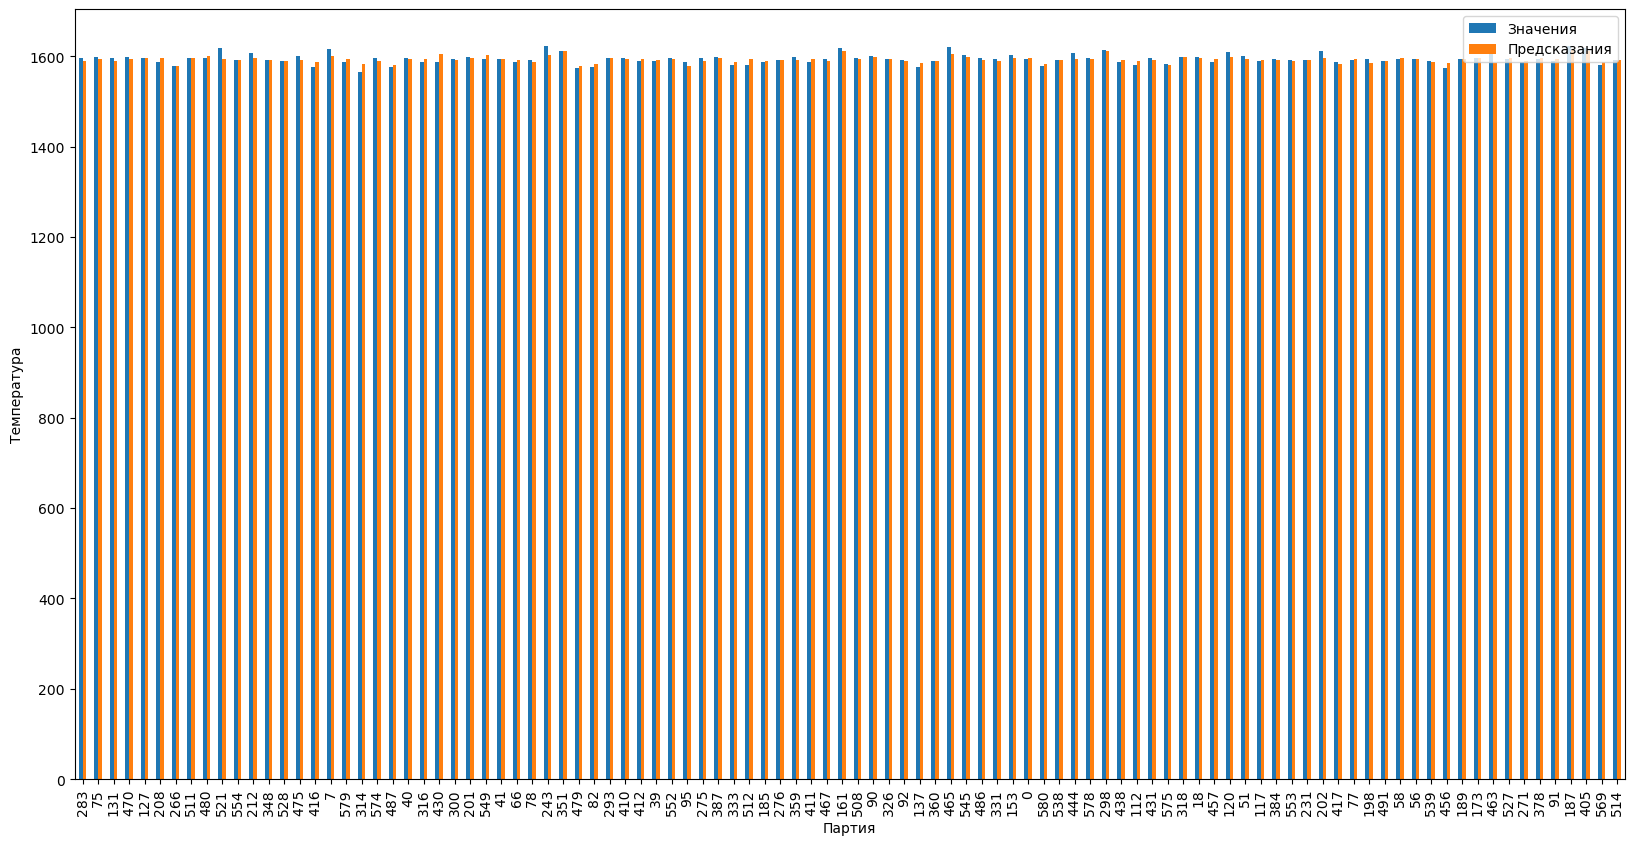

In [215]:
test_preds_df = pd.DataFrame(test_preds)
y_test_df = pd.DataFrame(y_test.values)
fig = pd.concat([y_test_df, test_preds_df], axis=1).sample(100).plot(kind='bar', figsize=(20, 10))
fig.legend(['Значения', 'Предсказания'])
fig.set_ylabel('Температура')
fig.set_xlabel('Партия');

In [241]:
features = [x for x in zip(X.columns, model.feature_importances_)]
features.sort(key=lambda x: -x[1])

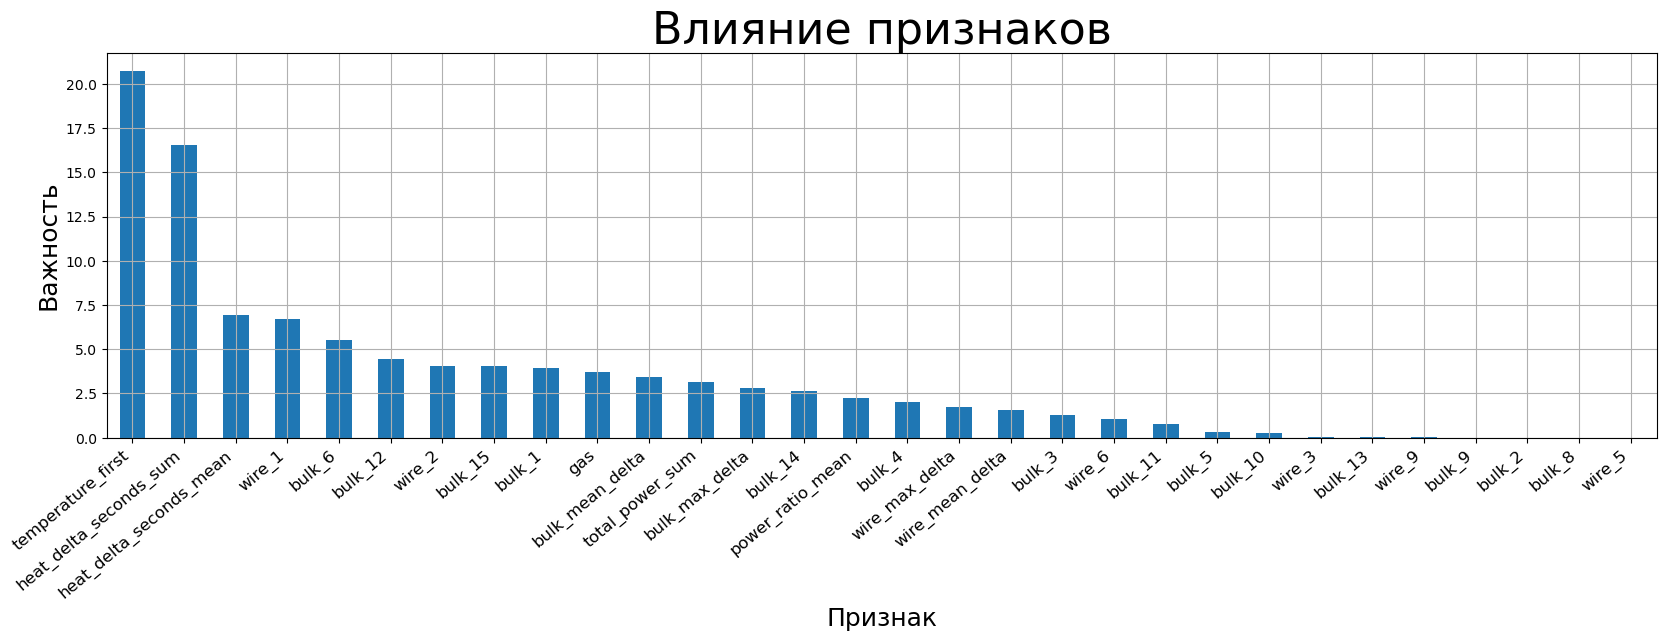

In [245]:
pd.DataFrame(features, columns=['feature', 'importance']).plot(kind='bar', x='feature', y='importance', grid=True, figsize=(20, 5))
plt.title('Влияние признаков', fontsize=32)
plt.xlabel('Признак', fontsize=18)
plt.ylabel('Важность', fontsize=18)
plt.xticks(fontsize=12, rotation=40, horizontalalignment='right')
plt.legend().remove();

10 наиболее влиятельных признаков:
- Начальная температура
- Суммарное время нагрева
- Время нагрева отдельных итераций
- Объем добавляемых материалов:
  - Сыпучие под номерами: 1, 6, 15
  - Проволочные под номерами: 1, 2
- Объем подаваемого газа

## Шаг 5. Общий вывод по работе

В ходе работы было произведено подключение к базе данных с последующей выгрузкой семи датасетов:
- `steel.data_arc` — данные об электродах. Таблица содержит несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки;
- `steel.data_bulk` — данные об объёме сыпучих материалов;
- `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
- `steel.data_gas` — данные о продувке сплава газом;
- `steel.data_temp` — данные об измерениях температуры. Таблица содержит несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки;
- `steel.data_wire` — данные об объёме проволочных материалов;
- `steel.data_wire_time` — данные о времени подачи проволочных материалов.

Исследовательский анализ показал, что некоторые таблицы содержат аномальные и пропущенные значения. Партии с аномальными значениями были исключены из датасета, а пропущенные значения были заполнены соответствующим образом. 

На следующем этапе данные были аггрегированы в один датасет с последющим анализом на мультиколлинеарность. В ходе анализа были обнаружены и в последствии исключены признаки с сильной корреляционной связью.

Далее датасет был разбит на обучающую и тестовую выборки. На обучающей выборке были обучены с кроссвалидацией следующие модели:
- Линейная регрессия
- Случайный лес
- CatBoost

Для обучения нейронной тренировочная выборка была дополнительно разбита на тренировочную и валидационную.

В результате обучения, наилучший результат показала модель градиентного бустинга. Метрика MAE лучшей модели показала значение 5.84. Что в сравнении с моделью "заглушкой", предсказывающей константное значение, показывающая MAE = 7.67, говорит нам о целесообразности данного исследования.

В качестве наиболее влиятельных признаков были определены следующие:
- Начальная температура
- Суммарное время нагрева
- Время нагрева отдельных итераций
- Объем добавляемых материалов:
- Сыпучие под номерами: 1, 6, 15
- Проволочные под номерами: 1, 2
- Объем подаваемого газа